In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler

# Download only the necessary NLTK resource
nltk.download('stopwords')
nltk.download('punkt')

# Load dataset
file_path = "/kaggle/input/mentalhealth2/MentalHealth_Updated2.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Keep only relevant columns and drop empty values
df = df[['statement', 'status']].dropna()

# Remove duplicate statements
df = df.drop_duplicates(subset=['statement'])

# Remove very short statements (less than 10 characters)
df = df[df['statement'].astype(str).apply(len) > 10]

# Remove statements that contain only special characters or numbers
df = df[df['statement'].apply(lambda x: not re.fullmatch(r'[^a-zA-Z]+', str(x)))]

# Truncate very long statements (over 1000 characters)
df['statement'] = df['statement'].astype(str).apply(lambda x: x[:1000])

# Text preprocessing steps applied directly
# Convert to lowercase
df['processed_statement'] = df['statement'].str.lower()

# Remove special characters and numbers
df['processed_statement'] = df['processed_statement'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Tokenization and stopword removal (skip lemmatization)
stop_words = set(stopwords.words('english'))

processed_texts = []
for text in df['processed_statement']:
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    processed_texts.append(' '.join(tokens))

df['processed_statement'] = processed_texts

# Balance the dataset using oversampling
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversample.fit_resample(
    df[['processed_statement', 'statement']], df['status']
)

df_balanced = pd.DataFrame({
    "statement": X_resampled['statement'],
    "processed_statement": X_resampled['processed_statement'], 
    "status": y_resampled
})

# Save the cleaned dataset
df_balanced.to_csv("MentalHealth_Cleaned.csv", index=False)
print("Dataset cleaned, preprocessed, and balanced successfully!")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Dataset cleaned, preprocessed, and balanced successfully!


**Model Training****

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import random

In [3]:
# Set seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True

In [4]:
# Check if GPU is available
def check_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
    return device

In [5]:
# Custom dataset class for mental health statements
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
# Load and prepare data
def load_and_prepare_data(file_path):
    try:
        print("Loading dataset...")
        df = pd.read_csv(file_path, encoding="ISO-8859-1")
        print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Check if required columns exist
        if 'statement' not in df.columns or 'status' not in df.columns:
            print("Error: Dataset must contain 'statement' and 'status' columns")
            return None, None
        
        # Fill missing values
        df['statement'] = df['statement'].fillna('')
        df['status'] = df['status'].fillna('unknown')
        
        # Drop rows with empty statements
        df_clean = df[df['statement'].str.strip() != '']
        print(f"After removing rows with empty statements: {df_clean.shape[0]} rows")
        
        # Display status distribution
        print("\nStatus Distribution:")
        print(df_clean['status'].value_counts())
        
        # Create label mapping
        labels = df_clean['status'].unique()
        label_dict = {label: i for i, label in enumerate(labels)}
        id_to_label = {i: label for label, i in label_dict.items()}
        
        # Convert labels to numeric
        df_clean['label'] = df_clean['status'].map(label_dict)
        
        return df_clean, label_dict, id_to_label
    
    except Exception as e:
        print(f"Error loading or processing dataset: {e}")
        return None, None, None


In [7]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, device, epochs=3):
    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    
    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    
    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    training_stats = []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 40)
        
        # Training
        model.train()
        total_train_loss = 0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(train_dataloader):
            # Progress update every 40 batches
            if batch_idx % 40 == 0 and batch_idx != 0:
                elapsed = time.time() - start_time
                print(f'Batch {batch_idx}/{len(train_dataloader)} Time: {elapsed:.2f}s')
                
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Clear previous gradients
            model.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip the norm of gradients to 1.0 to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
        # Calculate average loss over all batches
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = time.time() - start_time
        
        print(f"Average training loss: {avg_train_loss:.4f}")
        print(f"Training epoch took: {training_time:.2f}s")
        
        # Validation
        model.eval()
        total_eval_loss = 0
        all_preds = []
        all_labels = []
        
        print("Running validation...")
        
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
            loss = outputs.loss
            total_eval_loss += loss.item()
            
            # Get predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
        # Calculate average loss over all batches
        avg_val_loss = total_eval_loss / len(val_dataloader)
        
        print(f"Validation loss: {avg_val_loss:.4f}")
        
        # Calculate metrics
        val_report = classification_report(all_labels, all_preds, zero_division=0)
        print("\nValidation Classification Report:")
        print(val_report)
        
        # Save stats
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        })
        
    print("\nTraining complete!")
    return model, all_preds, all_labels


In [8]:
# Function to predict from new statements
def predict_mental_health_status(model, tokenizer, statements, id_to_label, device, max_length=128):
    if model is None:
        print("Error: Model is not available for prediction")
        return None
        
    try:
        # Ensure statements is a list
        if isinstance(statements, str):
            statements = [statements]
        
        model.eval()
        predictions = []
        probabilities = []
        
        for statement in statements:
            # Tokenize input
            encoding = tokenizer(
                statement,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            # Move to device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get prediction
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
            
            # Get predicted class
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            pred_class = torch.argmax(logits, dim=1).cpu().numpy()[0]
            
            # Map to label
            pred_label = id_to_label[pred_class]
            class_probs = probs.cpu().numpy()[0]
            
            predictions.append(pred_label)
            probabilities.append(class_probs)
        
        # Create results dataframe
        results = pd.DataFrame({
            'statement': statements,
            'predicted_status': predictions
        })
        
        # Add probability columns
        for i, label in id_to_label.items():
            results[f'probability_{label}'] = [prob[i] for prob in probabilities]
        
        return results
    
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None


Starting Mental Health Status Prediction System with Transformer Model
GPU available: Tesla P100-PCIE-16GB
Number of GPUs: 1
Loading dataset...
Dataset loaded successfully with 107849 rows and 3 columns
After removing rows with empty statements: 107849 rows

Status Distribution:
status
Anxiety                 15407
Normal                  15407
Depression              15407
Suicidal                15407
Stress                  15407
Bipolar                 15407
Personality disorder    15407
Name: count, dtype: int64
Training set: 86279 samples
Validation set: 10785 samples
Test set: 10785 samples
Loading distilbert-base-uncased tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting model training...

Epoch 1/3
----------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Batch 40/5393 Time: 4.67s
Batch 80/5393 Time: 8.62s
Batch 120/5393 Time: 12.56s
Batch 160/5393 Time: 16.50s
Batch 200/5393 Time: 20.45s
Batch 240/5393 Time: 24.40s
Batch 280/5393 Time: 28.34s
Batch 320/5393 Time: 32.29s
Batch 360/5393 Time: 36.23s
Batch 400/5393 Time: 40.18s
Batch 440/5393 Time: 44.12s
Batch 480/5393 Time: 48.07s
Batch 520/5393 Time: 52.01s
Batch 560/5393 Time: 55.95s
Batch 600/5393 Time: 59.89s
Batch 640/5393 Time: 63.84s
Batch 680/5393 Time: 67.79s
Batch 720/5393 Time: 71.73s
Batch 760/5393 Time: 75.68s
Batch 800/5393 Time: 79.62s
Batch 840/5393 Time: 83.57s
Batch 880/5393 Time: 87.52s
Batch 920/5393 Time: 91.46s
Batch 960/5393 Time: 95.42s
Batch 1000/5393 Time: 99.37s
Batch 1040/5393 Time: 103.31s
Batch 1080/5393 Time: 107.26s
Batch 1120/5393 Time: 111.20s
Batch 1160/5393 Time: 115.17s
Batch 1200/5393 Time: 119.13s
Batch 1240/5393 Time: 123.08s
Batch 1280/5393 Time: 127.03s
Batch 1320/5393 Time: 130.98s
Batch 1360/5393 Time: 134.92s
Batch 1400/5393 Time: 138.87s
Bat

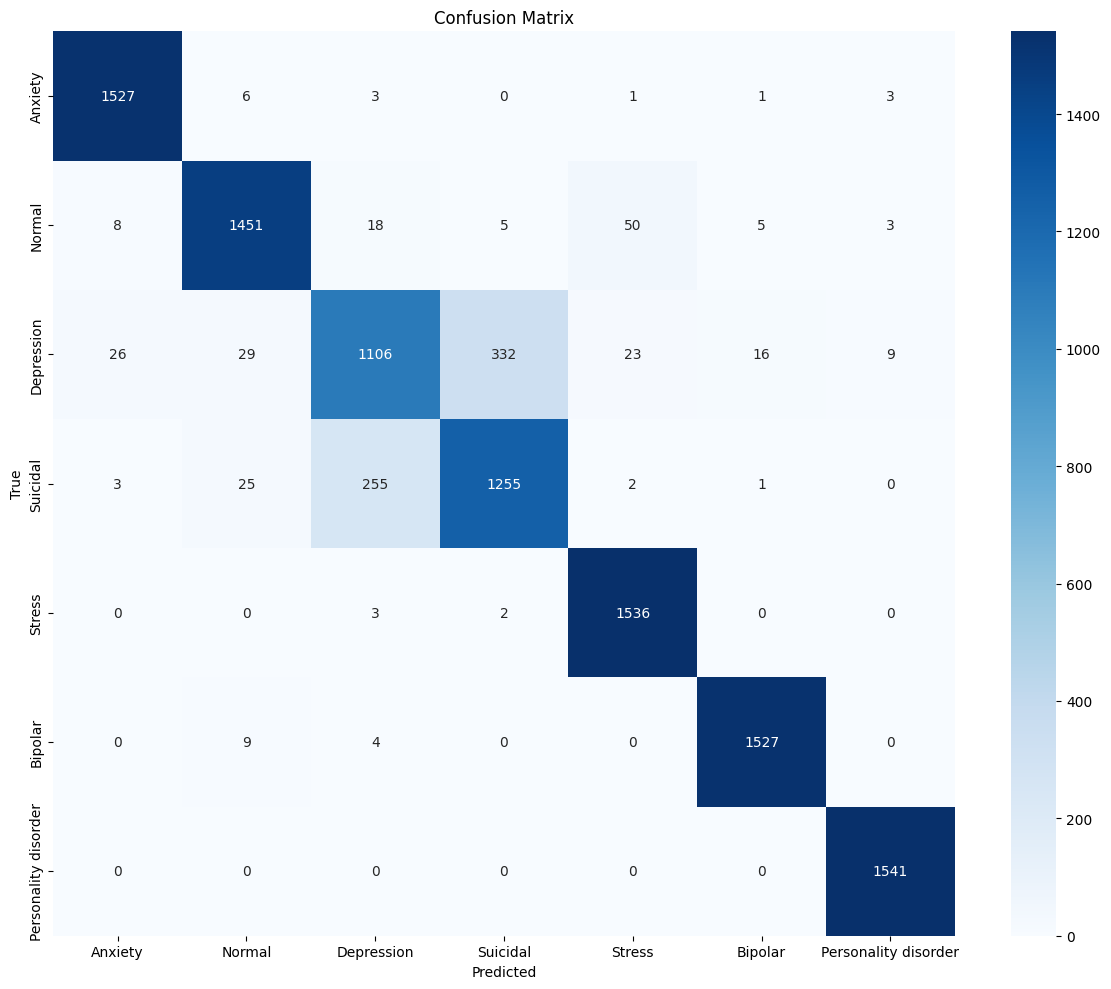

In [9]:
def main():
    print("Starting Mental Health Status Prediction System with Transformer Model")
    print("=" * 70)
    
    # Set random seed
    set_seed(42)
    
    # Check for GPU
    device = check_gpu()
    
    # Set file path
    file_path = '/kaggle/working/MentalHealth_Cleaned.csv'  # Replace with your dataset path
    
    # Load and prepare data
    df, label_dict, id_to_label = load_and_prepare_data(file_path)
    if df is None:
        return None, None, None, None
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df['statement'].values, df['label'].values, 
        test_size=0.2, random_state=42, stratify=df['label']
    )
    
    # Split test set into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Model selection - using DistilBERT for efficiency
    model_name = "distilbert-base-uncased"
    print(f"Loading {model_name} tokenizer and model...")
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(label_dict),
        id2label=id_to_label,
        label2id=label_dict
    )
    
    # Move model to device
    model.to(device)
    
    # Create datasets
    train_dataset = MentalHealthDataset(X_train, y_train, tokenizer)
    val_dataset = MentalHealthDataset(X_val, y_val, tokenizer)
    test_dataset = MentalHealthDataset(X_test, y_test, tokenizer)
    
    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Train the model
    print("\nStarting model training...")
    model, val_preds, val_labels = train_model(
        model, train_dataloader, val_dataloader, device, epochs=3
    )
    
    # Final evaluation on test set
    print("\nEvaluating on test set...")
    model.eval()
    test_preds = []
    test_labels = []
    
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        test_preds.extend(preds)
        test_labels.extend(labels.numpy())
    
    # Print final report
    print("\nFinal Test Classification Report:")
    report = classification_report(test_labels, test_preds, zero_division=0)
    print(report)
    
    # Generate confusion matrix
    print("Generating confusion matrix...")
    cm = confusion_matrix(test_labels, test_preds)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
               yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix_transformer.png')
    print("Confusion matrix saved as 'confusion_matrix_transformer.png'")
    
    # Save the model
    print("\nSaving model...")
    output_dir = './mental_health_transformer_model/'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    
    # Save label mapping
    import json
    with open(os.path.join(output_dir, 'label_mapping.json'), 'w') as f:
        json.dump(id_to_label, f)
        
    print(f"Model saved to {output_dir}")
    
    # Example of predicting on new statements
    print("\nTesting model with example statements...")
    test_statements = [
        "I feel very sad and empty all the time and nothing seems to help",
        "I'm having trouble sleeping and concentrating lately, I worry about everything",
        "I feel great today and looking forward to meeting friends, life is wonderful",
        "I keep worrying about everything and can't relax, my mind won't stop racing",
        "I'm experiencing extreme mood swings, sometimes I'm euphoric and other times deeply depressed",
        "I find it hard to relate to others and often feel misunderstood",
        "I often think about ending my life, nothing seems worth it anymore"
    ]
    
    results = predict_mental_health_status(model, tokenizer, test_statements, id_to_label, device)
    if results is not None:
        print("\nPredictions for new statements:")
        for i, row in results.iterrows():
            print(f"\nStatement: {row['statement']}")
            print(f"Predicted status: {row['predicted_status']}")
            
            # Get top probability
            status_col = f"probability_{row['predicted_status']}"
            if status_col in row:
                print(f"Confidence: {row[status_col]:.4f}")
    
    return model, tokenizer, id_to_label, device

if __name__ == "__main__":
    model, tokenizer, id_to_label, device = main()

    # Continuously test model with custom inputs
    # while True:
    #     print("\nTesting model with custom input...")
    #     statement = input("Enter a statement to predict mental health status (or 'exit' to quit): ")
        
    #     if statement.lower() == 'exit':
    #         break
        
    #     # Prepare custom input
    #     custom_statements = [statement]
        
    #     # Predict mental health status
    #     results = predict_mental_health_status(model, tokenizer, custom_statements, id_to_label, device)
        
    #     if results is not None:
    #         print(f"\nStatement: {results['statement'].iloc[0]}")
    #         print(f"Predicted status: {results['predicted_status'].iloc[0]}")
            
    #         # Get top probability
    #         status_col = f"probability_{results['predicted_status'].iloc[0]}"
    #         if status_col in results.columns:
    #             print(f"Confidence: {results[status_col].iloc[0]:.4f}")
    #     else:
    #         print("Failed to predict status.")
